<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/achromatic_metalens_rcwa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DFlat is built on top of Tensorflow's Keras. If you want to use GPU speedup for all executions, click runtime at the top and enable GPU acceleration. This is recommended to get results ~20-30x faster


# Cloning and Installing the repository


Be patient as installing tensorflow and other python packages may take a minute or so.

In [ ]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
fatal: destination path 'DFlat' already exists and is not an empty directory.


In [ ]:
%cd DFlat

/content/DFlat


In [ ]:
!python setup.py develop

running develop
running egg_info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/DFlat.egg-link (link to .)
DFlat 1.0.1 is already the active version in easy-install.pth

Installed /content/DFlat
Processing dependencies for DFlat==1.0.1
Finished processing dependencies for DFlat==1.0.1


In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Create a general optimization pipeline using the psf layer and the rcwa optical model 

A general class can be reused for different settings or loss functions as defined in the next section! This is why we structure the software flow like this!


In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy

import dflat.data_structure as df_struct
import dflat.optimization_helpers as df_optimizer
import dflat.physical_optical_layer as df_physical
import dflat.fourier_layer as df_fourier
import dflat.tools as df_tools

from dflat.physical_optical_layer.core.ms_parameterization import generate_cell_perm



It is convenient for inverse design to build off of DFlats df_optimizer.Pipeline_Object 

Inhereriting this class as the parent automatically manages checkpoint saving and loading for the custom keras model.



Most of the lines are used to define the visualizeTrainingCheckpoint. This is a plotting functions that will be called during save checkpoints (intermediary epochs) to monitor the process! Defining this function (overides parent class) is optional! If not included, no visualization plots will be made but the code will still run.

In the collab, these plots wont actually save since no google drive or harddrive is mounted but that is okay! we can always view plots manually at the end by tweaking the code and calling the function with plt.show()




In [ ]:
class pipeline_metalens_rcwa(df_optimizer.Pipeline_Object):
    def __init__(self, rcwa_settings, propagation_parameters, point_source_locs, savepath, saveAtEpochs=None):
        super(pipeline_metalens_rcwa, self).__init__(savepath, saveAtEpochs)

        copy_rcwa_settings = deepcopy(rcwa_settings)
        self.rcwa_parameters = df_struct.rcwa_params(rcwa_settings)
        self.propagation_parameters = propagation_parameters
        self.point_source_locs = point_source_locs

        # define computational layers
        self.rcwa_latent_layer = df_physical.RCWA_Latent_Layer(self.rcwa_parameters)
        self.psf_layer = df_fourier.PSF_Layer(propagation_parameters)

        # Make uniform state latent tensor as initial variable for metasurface with helper function
        input_shape = self.rcwa_latent_layer.shape_vect_size
        init_latent = 0.25 * tf.ones(shape=input_shape)
        self.latent_tensor_variable = tf.Variable(
            init_latent, trainable=True, dtype=tf.float32, name="metasurface_latent_tensor"
        )

        # modify rcwa_settings for visualization calls to display learned cells
        copy_rcwa_settings["batch_wavelength_dim"] = False
        self.mod_settings = df_struct.rcwa_params(copy_rcwa_settings)

    def __call__(self):
        out = self.rcwa_latent_layer(self.latent_tensor_variable)
        psf_intensity, _ = self.psf_layer(out, self.point_source_locs)
        # sum over the two polarization basis (x and y linear)
        psf_intensity = tf.reduce_sum(psf_intensity, axis=1)

        self.last_lens = out
        self.last_psf = psf_intensity
        return psf_intensity

    def visualizeTrainingCheckpoint(self, saveto, showPlot=False):
        # This overrides the baseclass visualization call function, called during checkpoints

        savefigpath = self.savepath + "/trainingOutput/"
        sim_wavelengths = self.propagation_parameters["wavelength_set_m"]
        num_wl = len(sim_wavelengths)

        xl, yl = df_fourier.getCoordinates_vector(
            self.propagation_parameters["ms_samplesM"],
            self.propagation_parameters["ms_dx_m"],
            True,
            tf.float32,
        )
        xd, yd = df_fourier.getCoordinates_vector(
            self.propagation_parameters["sensor_pixel_number"],
            self.propagation_parameters["sensor_pixel_size_m"],
            False,
            tf.float32,
        )

        Lx = self.mod_settings["Lx"]
        Ly = self.mod_settings["Ly"]

        # Display the learned phase and transmission profile on first row
        # and wavelength dependent PSFs on the second
        trans = self.last_lens[0]
        phase = self.last_lens[1]

        fig = plt.figure(figsize=(30, 20))
        ax = df_tools.addAxis(fig, 2, num_wl)
        for i in range(num_wl):
            ax[i].plot(xl[0, :] * 1e6, phase[i, 0, 0, :], "k--")
            ax[i].plot(xl[0, :] * 1e6, phase[i, 1, 0, :], "b--")
            ax[i].plot(xl[0, :] * 1e6, trans[i, 0, 0, :], "k*")
            ax[i].plot(xl[0, :] * 1e6, trans[i, 1, 0, :], "b*")
            df_tools.formatPlots(
                fig,
                ax[i],
                None,
                xlabel="Lens r (um)",
                ylabel="Phase and Transmission" if i == 0 else "",
                title="wavelength: " + f"{sim_wavelengths[i]*1e9:3.0f}",
            )

            ax[i + num_wl].imshow(
                self.last_psf[i, 0, :, :],
                extent=(np.min(xd) * 1e6, np.max(xd) * 1e6, np.min(yd) * 1e6, np.max(yd) * 1e6),
            )
            df_tools.formatPlots(fig, ax[i + num_wl], None, xlabel="det x (um)", ylabel="det y (um)")
        if not showPlot:
          plt.savefig(savefigpath + "png_images/" + saveto + "epoch_Lens.png")
          plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_Lens.pdf")
          plt.close()

        # Display some of the learned metacells
        latent_tensor_state = self.get_variable_by_name("metasurface_latent_tensor")[0]
        norm_shape_param = df_tools.latent_to_param(latent_tensor_state)
        ER, _ = generate_cell_perm(norm_shape_param, self.mod_settings)
        num_cells = phase.shape[3]
        disp_num = 5
        cell_idx = np.linspace(0, num_cells - 1, disp_num).astype(int)

        fig = plt.figure(figsize=(35, 7))
        ax = df_tools.addAxis(fig, 1, disp_num)
        for i, idx in enumerate(cell_idx):
            ax[i].imshow(
                np.abs(ER[1, idx, 0, 1, :, :]), extent=(np.min(0), np.max(Lx) * 1e9, np.min(0), np.max(Ly) * 1e9)
            )
            df_tools.formatPlots(
                fig,
                ax[i],
                None,
                xlabel="Cell x (nm)",
                ylabel="Cell y (nm)" if i == 0 else "",
                title="Lens r (um): " + f"{xl[0,idx]*1e6:3.0f}",
            )
        if not showPlot:
          plt.savefig(savefigpath + "png_images/" + saveto + "epoch_Cells.png")
          plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_Cells.pdf")
          plt.close()

        return


# Define Simulation Settings and run the optimization

In [ ]:
def run_achromatic_metalens(num_epochs=1, try_gpu=True):
    ## Define simulation parameters
    wavelength_list = [500e-9, 550e-9, 600e-9]
    point_source_locs = np.array([[0, 0, 1e6]])
    fourier_modes = 3 
    # In reality, one would want to use more modes (7+) but this
    # is just for a quick example run

    propagation_parameters = df_struct.prop_params(
        {
            "wavelength_set_m": wavelength_list,
            "ms_length_m": {"x": 200e-6, "y": 200e-6},
            "ms_dx_m": {"x": 4 * 350e-9, "y": 4 * 350e-9},
            "radius_m": None,
            "sensor_distance_m": 1e-3,
            "initial_sensor_dx_m": {"x": 2e-6, "y": 2e-6},
            "sensor_pixel_size_m": {"x": 2e-6, "y": 2e-6},
            "sensor_pixel_number": {"x": 101, "y": 101},
            "radial_symmetry": True,
            "diffractionEngine": "fresnel_fourier",
            "accurate_measurement": True,
        }
    )
    gridshape = propagation_parameters["grid_shape"]

    rcwa_settings = {
        "wavelength_set_m": wavelength_list,
        "thetas": [0.0 for i in wavelength_list],
        "phis": [0.0 for i in wavelength_list],
        "pte": [1.0 for i in wavelength_list],
        "ptm": [1.0 for i in wavelength_list],
        "pixelsX": gridshape[2],
        "pixelsY": gridshape[1],
        "PQ": [fourier_modes, fourier_modes],
        "Lx": 350e-9,
        "Ly": 350e-9,
        "L": [1e-3, 600.0e-9, 1e-3],
        "Lay_mat": ["SiO2", "Vacuum", "Vacuum"],
        "material_dielectric": "TiO2",
        "er1": "Vacuum",
        "er2": "Vacuum",
        "Nx": 256,
        "Ny": 256,
        "parameterization_type": "coupled_rectangular_resonators",
        "batch_wavelength_dim": True,
    }

    # Define save path
    savepath = "images/"
    if not os.path.exists(savepath):
        os.makedirs(savepath)

    ## Call optimization pipeline
    pipeline = pipeline_metalens_rcwa(
        rcwa_settings, propagation_parameters, point_source_locs, savepath, saveAtEpochs=10
    )
    pipeline.customLoad()  # restore previous checkpoint if it exists

    ## Define custom Loss function (Should always have pipeline_output as the function input)
    sensor_pixel_number = propagation_parameters["sensor_pixel_number"]
    cidx_y = sensor_pixel_number["y"] // 2
    cidx_x = sensor_pixel_number["x"] // 2

    def loss_fn(pipeline_output):
        return -tf.reduce_sum(pipeline_output[:, 0, cidx_y, cidx_x])

    learning_rate = 1e-1
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    df_optimizer.run_pipeline_optimization(pipeline, optimizer, num_epochs=num_epochs, loss_fn=loss_fn, allow_gpu=try_gpu)


    # Explicitly call and show the plot from visualizeCheckpoint
    # Normally this is saved in a folder and you wouldn't call it manually
    pipeline.visualizeTrainingCheckpoint(saveto="", showPlot=True)
    plt.show()

    return


Checking for model checkpoint at: images/

 Model Checkpoint Loaded 

Training Log | (Step, time, loss):  0 26.619537353515625 -0.03214792544225098
Training Log | (Step, time, loss):  1 23.87576937675476 -0.03683081942042431
Training Log | (Step, time, loss):  2 24.461918830871582 -0.03991077241434385
Training Log | (Step, time, loss):  3 23.901244401931763 -0.044414996531236386
Training Log | (Step, time, loss):  4 23.183871746063232 -0.04831866462963449
Training Log | (Step, time, loss):  5 22.936609506607056 -0.05216867775578316
Training Log | (Step, time, loss):  6 30.411628246307373 -0.05597912328449445
Training Log | (Step, time, loss):  7 24.533012866973877 -0.05835189332367141
Training Log | (Step, time, loss):  8 23.58025336265564 -0.059920854732259124
Training Log | (Step, time, loss):  9 23.622269868850708 -0.06250915121725244
Training Log | (Step, time, loss):  10 23.36998224258423 -0.061312958527768024
Log Training at step: 10

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  11 23.43970823287964 -0.06635466843852979
Training Log | (Step, time, loss):  12 23.484748601913452 -0.06464629345847792
Training Log | (Step, time, loss):  13 23.550581693649292 -0.06691714654337765
Training Log | (Step, time, loss):  14 24.43155336380005 -0.06621715462262973
Training Log | (Step, time, loss):  15 23.44402813911438 -0.06834210694369443
Training Log | (Step, time, loss):  16 23.446494579315186 -0.06929208918513981
Training Log | (Step, time, loss):  17 23.552942991256714 -0.06955918451890508
Training Log | (Step, time, loss):  18 24.548991680145264 -0.06813234720015993
Training Log | (Step, time, loss):  19 23.389689207077026 -0.07012747237885614

 Model Saved Succesfully 



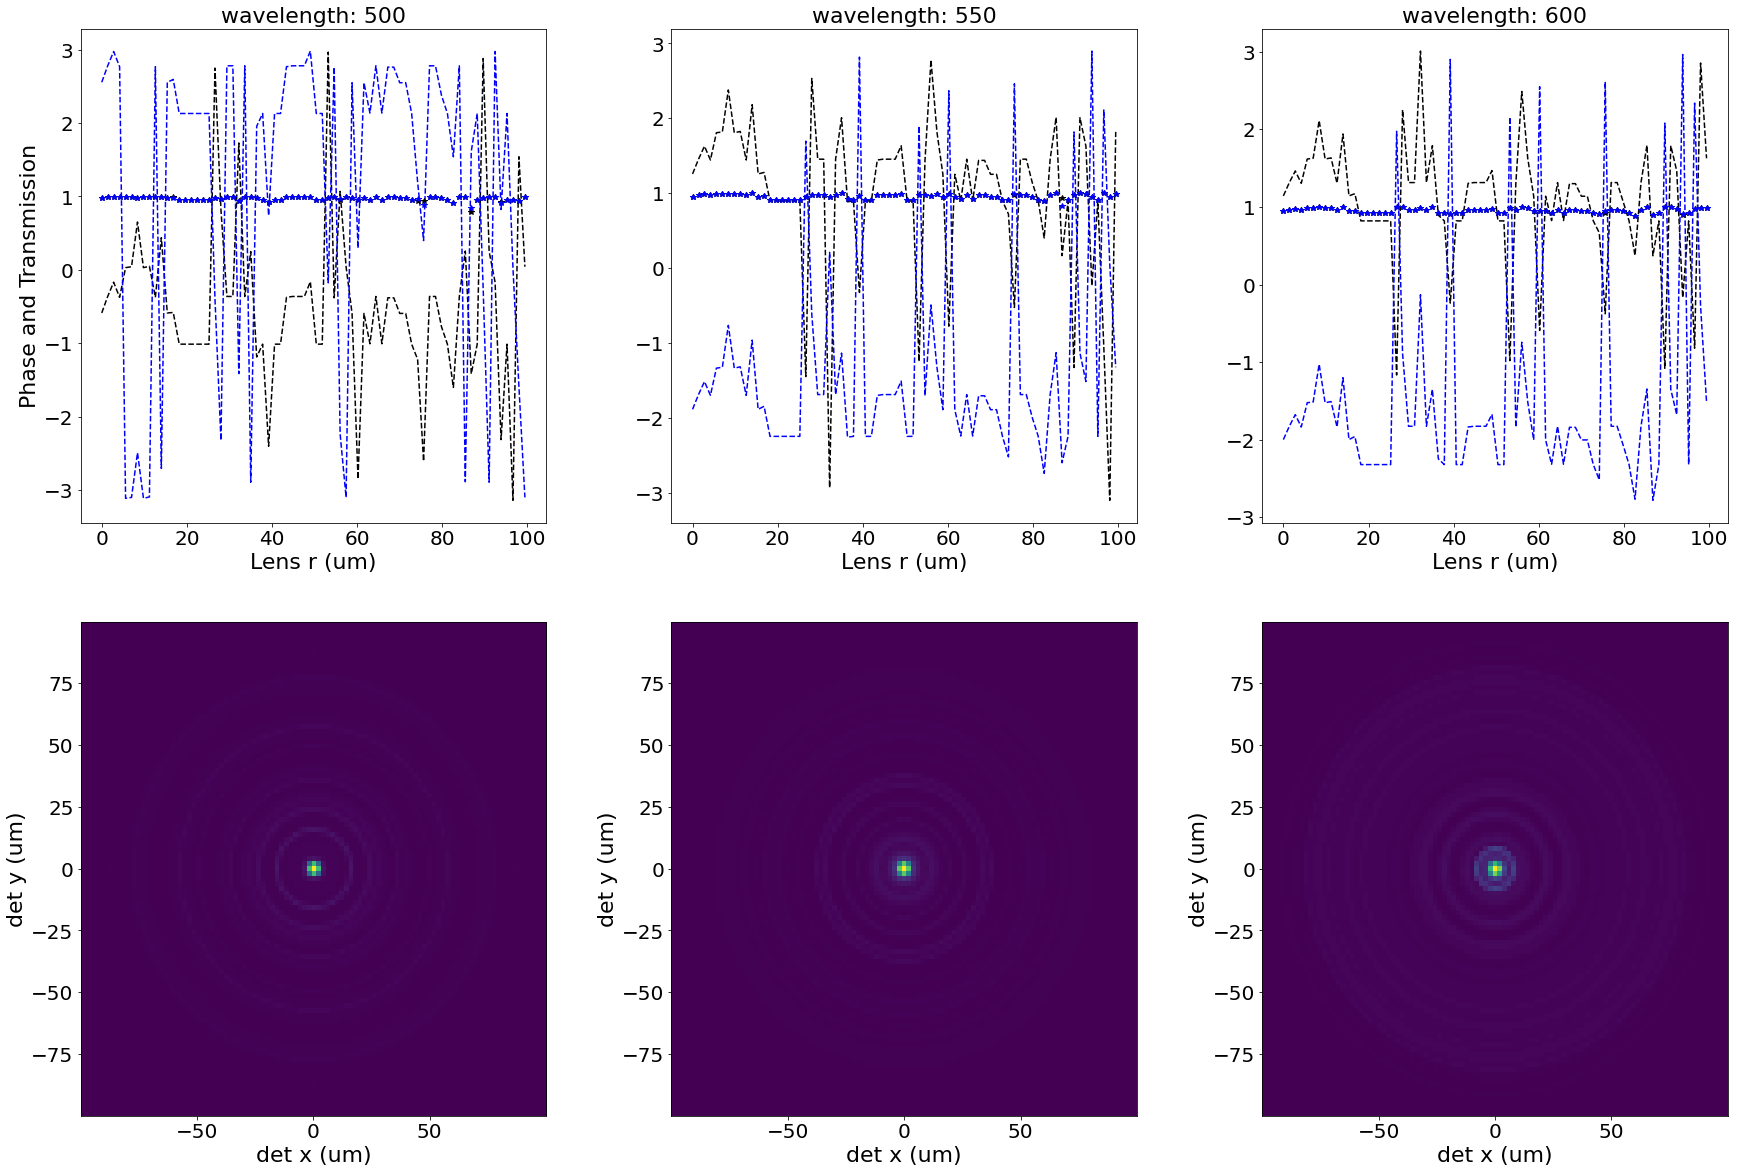

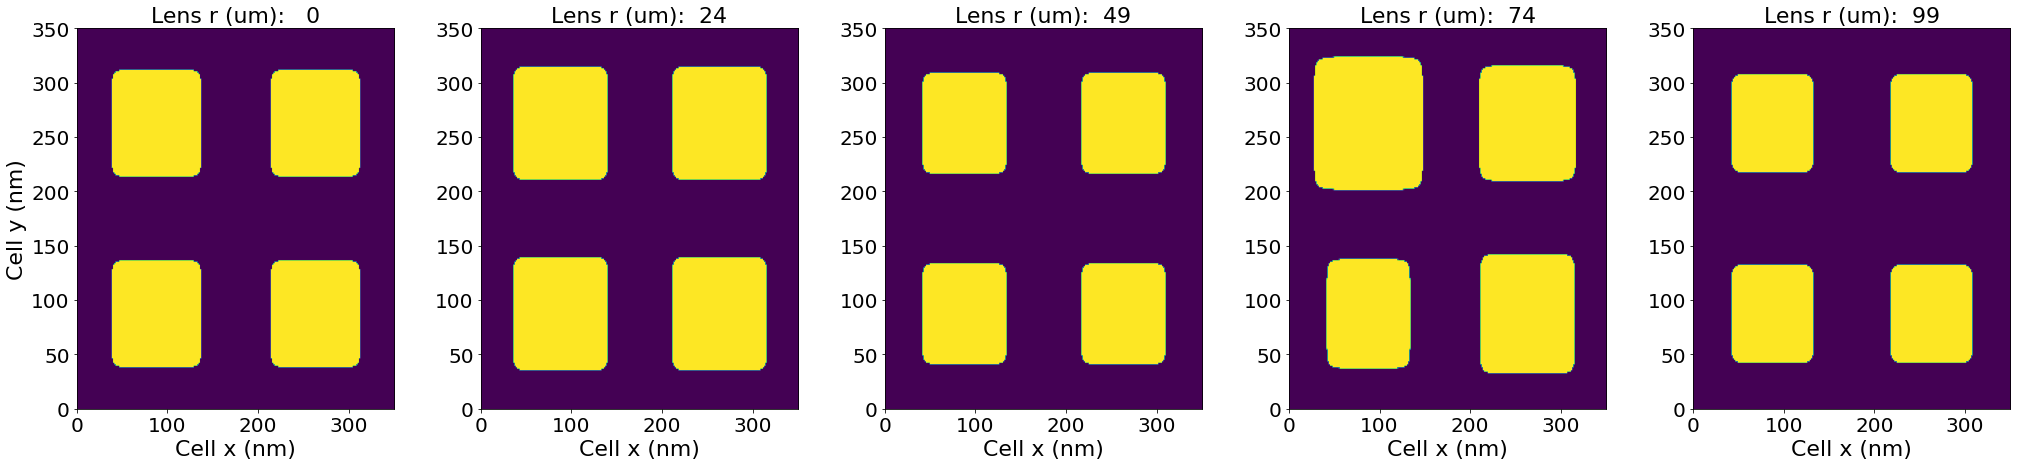

In [ ]:

run_achromatic_metalens(num_epochs=20, try_gpu=True)
